['An array of Antipasti to include Stuffed Olives, Artichoke Hearts, Roasted Red Bell Pepper and Marinated Mushroom, Fresh Mozzarella and Roasted Pepper with Olive Dressing.\nAn array of sandwich delights.. Cucumber and Spinach, Chicken Salad, tomato and Cucumber, just to mention a few.\nA beautiful array of Fresh Fruit , Imported and Domestic Cheeses with Rustic European Breads.\nFrench Baguette with Roasted Garlic, Goat Cheese and homemade Apple Chutney.\nMushrooms stuffed with Escargot, Goat Cheese and Caramelized Onions.\nSmall New Potatoes with Goat Cheese and Rosemary. Served warm.\nStuffed New Potatoes with Basil Pesto. Served warm.\nSmall New Potatoes stuffed with Smoked Salmon and Horseradish. Served warm.\nOurs are homemade and simply the best in town.\nMushrooms stuffed with Leeks, Roasted Garlic and two Cheeses.\nMushrooms stuffed with Spinach, Feta and Apple Smoked Bacon.\nSmall New Potatoes stuffed with Gorgonzola Cream, Bacon and Walnuts. Served warm.\nSlices of French B

Baseline Processing for Sample 1: 100%|██████████| 10/10 [01:05<00:00,  6.58s/it]
Token indices sequence length is longer than the specified maximum sequence length for this model (634 > 512). Running this sequence through the model will result in indexing errors
Processing Samples: 100%|██████████| 3/3 [1:38:44<00:00, 1974.76s/it]


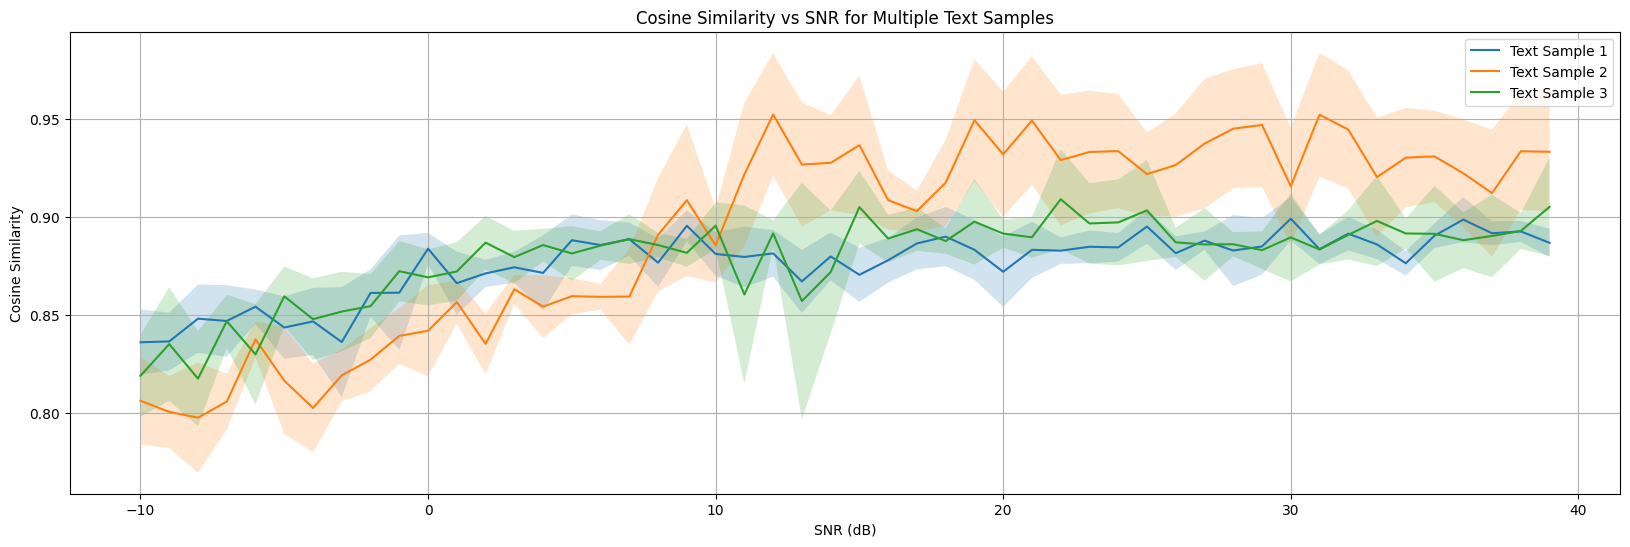

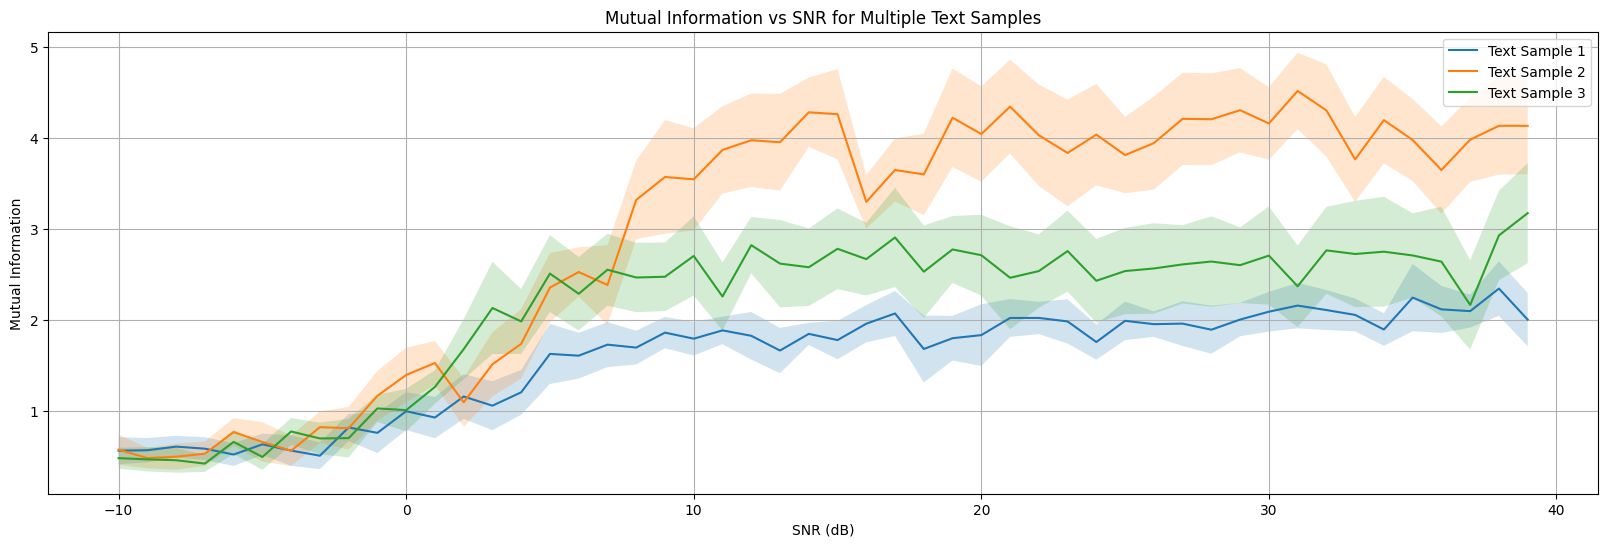

In [8]:
# Original imports and setup
from transformers import BartTokenizer, BartForConditionalGeneration
from transformers.modeling_outputs import BaseModelOutput
from transformers import T5Tokenizer, T5ForConditionalGeneration
from IPython.display import display, HTML
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils import *  # Assuming helper functions like masking, add_noise_with_snr, etc., are defined here
import json
import numpy as np


# Automatically choose (prefer NVIDIA GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Specify model name
model_name = "facebook/bart-base"
tokenizer_bart = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name).to(device)

# Specify model name for the summarizer
summarizer_name = "Falconsai/text_summarization"
tokenizer_sum = T5Tokenizer.from_pretrained(summarizer_name)
summarizer = T5ForConditionalGeneration.from_pretrained(summarizer_name).to(device)

# File path for the JSONL file
file_path = r"E:\info_project\Information-Secrecy-using-LLMs\dataset\3_samples.jsonl"  # Replace with your actual file path
texts = []
with open(file_path, "r") as f:
    for line in f:
        data = json.loads(line)
        texts.append(data["text"])
print(texts)
# Define parameters
nr_rounds = 10
snr_range = list(range(-10, 40, 1))

# Storage for results
all_cs_list_mean = []
all_cs_list_lower = []
all_cs_list_upper = []
all_mi_list_mean = []
all_mi_list_lower = []
all_mi_list_upper = []

# Process each text sample
for text_index, text in enumerate(tqdm(texts, desc="Processing Samples")):
    input_text_ls = [masking(text, 4 / len(text)) for _ in range(nr_rounds)]

    # Generate baseline summaries and embeddings for the current text
    em_baseline_summary = []
    for i in tqdm(range(nr_rounds), desc=f"Baseline Processing for Sample {text_index + 1}"):
        input_ids = tokenizer_bart(input_text_ls[i], return_tensors="pt").input_ids.to(device)
        with torch.no_grad():
            encoder_outputs = model.model.encoder(input_ids=input_ids)

        baseline_outputs = model.generate(input_ids=None, encoder_outputs=encoder_outputs, max_length=300, min_length=100,
                                            num_beams=15, do_sample=True, temperature=0.15, early_stopping=True)
        baseline_text = tokenizer_bart.decode(baseline_outputs[0], skip_special_tokens=True)
        baseline_ids = tokenizer_sum(baseline_text, return_tensors="pt").input_ids.to(device)
        with torch.no_grad():
            baseline_encoder_outputs = summarizer.encoder(input_ids=baseline_ids)
        baseline_sum_output = summarizer.generate(input_ids=None, encoder_outputs=baseline_encoder_outputs, max_length=70,
                                                    output_hidden_states=True, return_dict_in_generate=True,
                                                    do_sample=True, temperature=0.1)
        em_baseline_summary.append(extract_hidden_states(baseline_sum_output.decoder_hidden_states))
        # Process noisy embeddings and calculate metrics for the current text
    cs_list_mean = []
    cs_list_lower = []
    cs_list_upper = []
    mi_list_mean = []
    mi_list_lower = []
    mi_list_upper = []

    for target_snr in tqdm(snr_range, desc=f"SNR Range for Sample {text_index + 1}"):
        cs_list_texts = []
        mi_list_texts = []
        for i in range(nr_rounds):
            input_ids = tokenizer_bart(input_text_ls[i], return_tensors="pt").input_ids.to(device)
            with torch.no_grad():
                encoder_outputs = model.model.encoder(input_ids=input_ids)

            noisy_encoder_output = add_noise_with_snr(encoder_outputs.last_hidden_state, "gaussian", target_snr, 0.4, 0.4)
            modified_encoder_outputs = BaseModelOutput(last_hidden_state=noisy_encoder_output)

            noisy_outputs = model.generate(input_ids=None, encoder_outputs=modified_encoder_outputs, max_length=300, min_length=100,
                                            num_beams=15, do_sample=True, temperature=0.15, early_stopping=True)
            noisy_text = tokenizer_bart.decode(noisy_outputs[0], skip_special_tokens=True)
            noisy_ids = tokenizer_sum(noisy_text, return_tensors="pt").input_ids.to(device)
            with torch.no_grad():
                noisy_encoder_outputs = summarizer.encoder(input_ids=noisy_ids)
            noisy_sum_output = summarizer.generate(input_ids=None, encoder_outputs=noisy_encoder_outputs, max_length=70,
                                                    output_hidden_states=True, return_dict_in_generate=True,
                                                    do_sample=True, temperature=0.1)
            em_noisy_summary = extract_hidden_states(noisy_sum_output.decoder_hidden_states)

            # Align tensors
            pad_em_baseline_summary, pad_em_noisy_summary = align_tensors(em_baseline_summary[i], em_noisy_summary)

            # Calculate metrics
            cs_list_texts.append(F.cosine_similarity(pad_em_baseline_summary, pad_em_noisy_summary, dim=1).mean().item())
            em_noisy_summary_np = em_noisy_summary.cpu().numpy()
            em_baseline_summary_np = em_baseline_summary[i].cpu().numpy()
            mi_list_texts.append(ksg(em_baseline_summary_np, em_noisy_summary_np))

        # Aggregate results for the current SNR
        cs_list_mean.append(np.mean(cs_list_texts))
        mi_list_mean.append(np.mean(mi_list_texts))

        z = 1.96  # For 95% confidence interval
        cs_list_std = np.std(cs_list_texts, axis=0)
        margin_of_error = z * (cs_list_std / np.sqrt(nr_rounds))
        cs_list_lower.append(cs_list_mean[-1] - margin_of_error)
        cs_list_upper.append(cs_list_mean[-1] + margin_of_error)

        mi_list_std = np.std(mi_list_texts, axis=0)
        margin_of_error = z * (mi_list_std / np.sqrt(nr_rounds))
        mi_list_lower.append(mi_list_mean[-1] - margin_of_error)
        mi_list_upper.append(mi_list_mean[-1] + margin_of_error)

    # Store results for the current text sample
    all_cs_list_mean.append(cs_list_mean)
    all_cs_list_lower.append(cs_list_lower)
    all_cs_list_upper.append(cs_list_upper)
    all_mi_list_mean.append(mi_list_mean)
    all_mi_list_lower.append(mi_list_lower)
    all_mi_list_upper.append(mi_list_upper)

# Plot results for all text samples
plt.figure(figsize=(20, 6))
for i in range(len(texts)):
    plt.plot(snr_range, all_cs_list_mean[i], label=f"Text Sample {i + 1}")
    plt.fill_between(snr_range, all_cs_list_lower[i], all_cs_list_upper[i], alpha=0.2)
plt.xlabel("SNR (dB)")
plt.ylabel("Cosine Similarity")
plt.title("Cosine Similarity vs SNR for Multiple Text Samples")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(20, 6))
for i in range(len(texts)):
    plt.plot(snr_range, all_mi_list_mean[i], label=f"Text Sample {i + 1}")
    plt.fill_between(snr_range, all_mi_list_lower[i], all_mi_list_upper[i], alpha=0.2)
plt.xlabel("SNR (dB)")
plt.ylabel("Mutual Information")
plt.title("Mutual Information vs SNR for Multiple Text Samples")
plt.legend()
plt.grid()
plt.show()

    

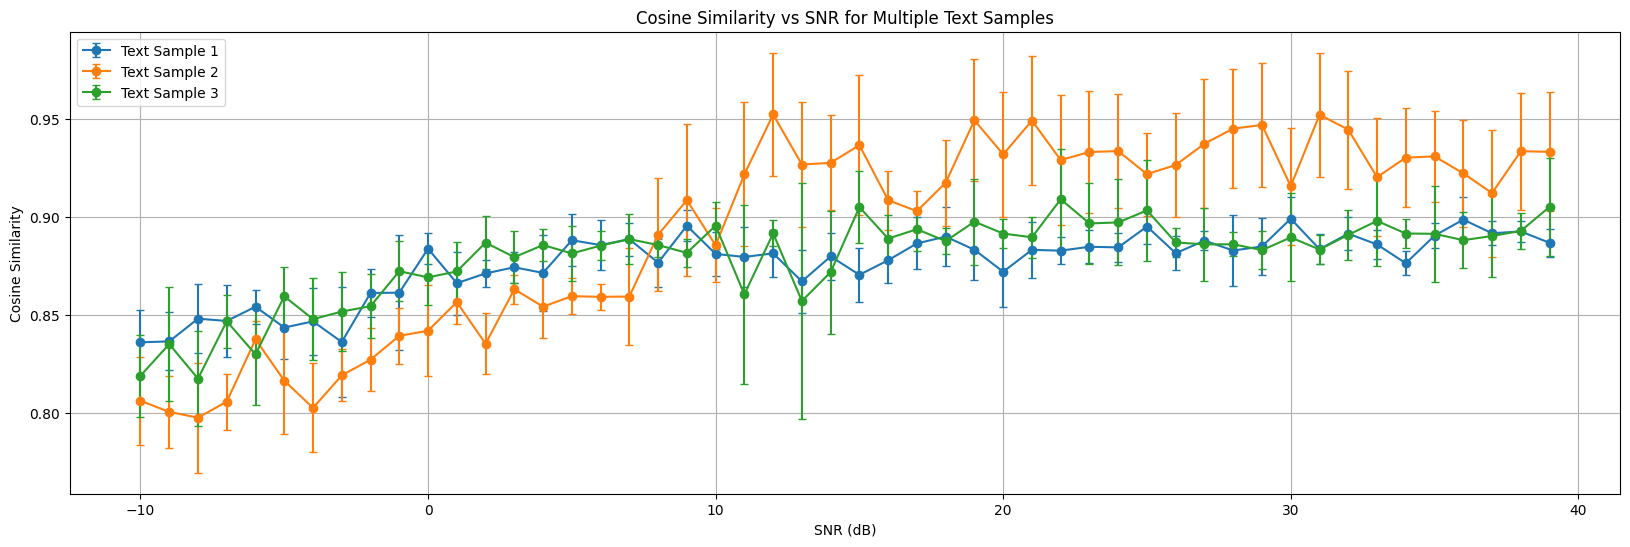

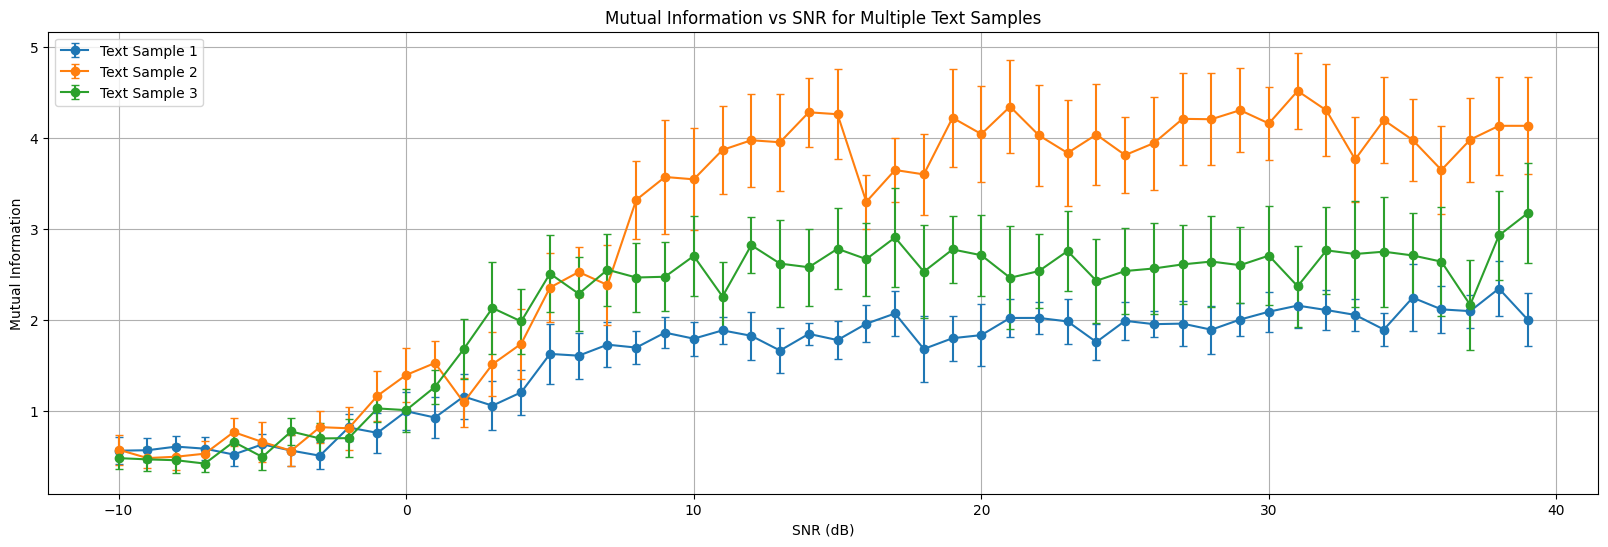

In [4]:
import numpy as np
import matplotlib.pyplot as plt
# Plot results for Cosine Similarity with error bars
plt.figure(figsize=(20, 6))
for i in range(3):
    mean = np.array(all_cs_list_mean[i])
    lower = np.array(all_cs_list_lower[i])
    upper = np.array(all_cs_list_upper[i])
    error = [mean - lower, upper - mean]
    plt.errorbar(snr_range, mean, yerr=error, label=f"Text Sample {i + 1}", fmt='-o', capsize=3)
plt.xlabel("SNR (dB)")
plt.ylabel("Cosine Similarity")
plt.title("Cosine Similarity vs SNR for Multiple Text Samples")
plt.legend()
plt.grid()
plt.show()

# Plot results for Mutual Information with error bars
plt.figure(figsize=(20, 6))
for i in range(3):
    mean = np.array(all_mi_list_mean[i])
    lower = np.array(all_mi_list_lower[i])
    upper = np.array(all_mi_list_upper[i])
    error = [mean - lower, upper - mean]
    plt.errorbar(snr_range, mean, yerr=error, label=f"Text Sample {i + 1}", fmt='-o', capsize=3)
plt.xlabel("SNR (dB)")
plt.ylabel("Mutual Information")
plt.title("Mutual Information vs SNR for Multiple Text Samples")
plt.legend()
plt.grid()
plt.show()


In [11]:

import pandas as pd

# 将数据整合到一个字典中
data_dict = {
    "SNR": snr_range,
}

# 遍历每个文本样本的数据
for i in range(len(texts)):
    data_dict[f"CS_Mean_Text_{i+1}"] = all_cs_list_mean[i]
    data_dict[f"CS_Lower_Text_{i+1}"] = all_cs_list_lower[i]
    data_dict[f"CS_Upper_Text_{i+1}"] = all_cs_list_upper[i]
    data_dict[f"MI_Mean_Text_{i+1}"] = all_mi_list_mean[i]
    data_dict[f"MI_Lower_Text_{i+1}"] = all_mi_list_lower[i]
    data_dict[f"MI_Upper_Text_{i+1}"] = all_mi_list_upper[i]

# 转换为 DataFrame
df = pd.DataFrame(data_dict)

# 保存为 CSV 文件
csv_filename = "plot_data.csv"
df.to_csv(csv_filename, index=False)

print(f"数据已保存到 {csv_filename}")



数据已保存到 plot_data.csv


In [12]:
import json

# 创建保存的字典
data_json = {
    "SNR": snr_range,
    "Cosine_Similarity": [
        {
            "Mean": all_cs_list_mean[i],
            "Lower": all_cs_list_lower[i],
            "Upper": all_cs_list_upper[i],
        }
        for i in range(len(texts))
    ],
    "Mutual_Information": [
        {
            "Mean": all_mi_list_mean[i],
            "Lower": all_mi_list_lower[i],
            "Upper": all_mi_list_upper[i],
        }
        for i in range(len(texts))
    ],
}

# 保存为 JSON 文件
json_filename = "plot_data.json"
with open(json_filename, "w") as f:
    json.dump(data_json, f, indent=4)

print(f"数据已保存到 {json_filename}")


数据已保存到 plot_data.json


In [1]:
# 读取 CSV 文件
import pandas as pd

csv_filename = "plot_data.csv"
df = pd.read_csv(csv_filename)

# 查看数据
print(df.head())

# 使用数据
snr_range = df["SNR"].values
all_cs_list_mean = [df[f"CS_Mean_Text_{i+1}"].values for i in range(len(df.columns) // 6)]
all_cs_list_lower = [df[f"CS_Lower_Text_{i+1}"].values for i in range(len(df.columns) // 6)]
all_cs_list_upper = [df[f"CS_Upper_Text_{i+1}"].values for i in range(len(df.columns) // 6)]
all_mi_list_mean = [df[f"MI_Mean_Text_{i+1}"].values for i in range(len(df.columns) // 6)]
all_mi_list_lower = [df[f"MI_Lower_Text_{i+1}"].values for i in range(len(df.columns) // 6)]
all_mi_list_upper = [df[f"MI_Upper_Text_{i+1}"].values for i in range(len(df.columns) // 6)]


   SNR  CS_Mean_Text_1  CS_Lower_Text_1  CS_Upper_Text_1  MI_Mean_Text_1  \
0  -10        0.836137         0.819481         0.852793        0.568286   
1   -9        0.836569         0.821792         0.851346        0.573155   
2   -8        0.848195         0.830722         0.865668        0.613013   
3   -7        0.847016         0.828748         0.865284        0.590355   
4   -6        0.854301         0.845522         0.863079        0.526065   

   MI_Lower_Text_1  MI_Upper_Text_1  CS_Mean_Text_2  CS_Lower_Text_2  \
0         0.420573         0.715999        0.806250         0.783881   
1         0.439129         0.707182        0.800571         0.782190   
2         0.494073         0.731952        0.797624         0.769499   
3         0.464784         0.715926        0.805807         0.791525   
4         0.401633         0.650497        0.837626         0.828479   

   CS_Upper_Text_2  MI_Mean_Text_2  MI_Lower_Text_2  MI_Upper_Text_2  \
0         0.828619        0.579597    

In [14]:
# 读取 JSON 文件
import json

json_filename = "plot_data.json"
with open(json_filename, "r") as f:
    data_json = json.load(f)

# 查看数据
print(data_json)

# 使用数据
snr_range = data_json["SNR"]
all_cs_list_mean = [sample["Mean"] for sample in data_json["Cosine_Similarity"]]
all_cs_list_lower = [sample["Lower"] for sample in data_json["Cosine_Similarity"]]
all_cs_list_upper = [sample["Upper"] for sample in data_json["Cosine_Similarity"]]
all_mi_list_mean = [sample["Mean"] for sample in data_json["Mutual_Information"]]
all_mi_list_lower = [sample["Lower"] for sample in data_json["Mutual_Information"]]
all_mi_list_upper = [sample["Upper"] for sample in data_json["Mutual_Information"]]


{'SNR': [-10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39], 'Cosine_Similarity': [{'Mean': [0.8361368298530578, 0.8365688860416413, 0.8481950342655182, 0.8470162868499755, 0.854300594329834, 0.8436635553836822, 0.8467992126941681, 0.8362605392932891, 0.8613373219966889, 0.8614660263061523, 0.8839369297027588, 0.8663376033306122, 0.8713108956813812, 0.8744492113590241, 0.8715653121471405, 0.8882652938365936, 0.8857940316200257, 0.8888028264045715, 0.8767925798892975, 0.8956656932830811, 0.8812634527683259, 0.8797239124774933, 0.8815641522407531, 0.8672352850437164, 0.8799785315990448, 0.8705931186676026, 0.878053343296051, 0.8866303920745849, 0.8901170492172241, 0.8833892345428467, 0.872156697511673, 0.8833589494228363, 0.8829357743263244, 0.8849294722080231, 0.8846047580242157, 0.8952672600746154, 0.8816376268863678, 0.8880534529685974, 0.88300982